# This notebook contains the tuning of ResNet50, VGG16, and DenseNet121 for transfer learning with all transferred layers frozen

See the accomponied 'overview_tuning_transfer_learning' Excel file for a quick overview of all investigated hyperparameters and associated performance. In addition, to investigate our hypothesis that freezing all layers leads to lower model performance due to the final convolutional layers looking for filters/features that are not present in the MRI data, we also tuned some models with less layers frozen. To keep things concise, we have not included the code for this in the current notebook, but the description of the models and its results can be seen in the mentioned Excel file.

# 1. Import libraries

In [2]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from google.colab import drive
import numpy as np

# From here, add any libraries that you might need for the rest of your code
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, GlobalAveragePooling2D, BatchNormalization, Lambda
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
import matplotlib.pyplot as plt
print(keras.__version__)
print(tf.__version__)

3.5.0
2.17.0


# 2. Load and pre-process the dataset

In [3]:
# drive.mount('/content/drive')

In [4]:
# Set the paths based on your Drive directory
data_dir = r'D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")


Data directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset
Training directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset\Training
Testing directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset\Testing


In [5]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 2.1 Splitting off validation set

In [6]:
# splitting validation set from train_data
# extract images and labels from train_data
class_indices = train_data.class_indices
images = []
labels = []

for i in range(len(train_data)):
    img, lbl = train_data[i]
    images.append(img)
    labels.append(lbl)

# concatenate lists to numpy arrays
images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

# split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.25, random_state=42)

# create ImageDataGenerator instances
datagen = ImageDataGenerator()

# create new iterators for training and validation sets
train_data = datagen.flow(train_images, train_labels, batch_size=32, shuffle=True)
val_data = datagen.flow(val_images, val_labels, batch_size=32, shuffle=False)

# store class_indices and labels in the new iterators
train_data.class_indices = class_indices
train_data.labels = train_labels

val_data.class_indices = class_indices
val_data.labels = val_labels

# sanity check for train_data
for images, labels in train_data:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for val_data
for images, labels in val_data:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break 

Processed image shape: (32, 30, 30, 1)
Label shape: (32, 4)
Processed image shape: (32, 30, 30, 1)
Label shape: (32, 4)


In [7]:
print(f'Number of training samples: {train_data.n}')
print(f'Number of validation samples: {val_data.n}')
print(f'Number of test samples: {test_data.n}')

Number of training samples: 4284
Number of validation samples: 1428
Number of test samples: 1311


## 2.2 Rescaling image data for required size of transfer learning models

In [8]:
# resize train_data, val_data, and test_data beforehand
# set image size for resizing
target_image_size = 90

# actual rescaling function
def preprocess_image(image):
    # Resize the image
    image = tf.image.resize(image, [target_image_size, target_image_size])
    # Convert grayscale to RGB if necessary
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image

# function to rescale images of train_data, val_data, and test_data
def preprocess_data(data):
    images = []
    labels = []
    for i in range(len(data)):
        img, lbl = data[i]
        img = preprocess_image(img).numpy()
        images.append(img)
        labels.append(lbl)
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# rescale images
train_images, train_labels = preprocess_data(train_data)
val_images, val_labels = preprocess_data(val_data)
test_images, test_labels = preprocess_data(test_data)

# Create new ImageDataGenerator instances
datagen = ImageDataGenerator()

# create new iterators for training, validation, and test sets with preprocessed images
train_data_rescaled = datagen.flow(train_images, train_labels, batch_size=32, shuffle=True)
val_data_rescaled = datagen.flow(val_images, val_labels, batch_size=32, shuffle=False)
test_data_rescaled = datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

# store class_indices and labels in the new iterators
train_data_rescaled.class_indices = train_data.class_indices
train_data_rescaled.labels = train_labels

val_data_rescaled.class_indices = val_data.class_indices
val_data_rescaled.labels = val_labels

test_data_rescaled.class_indices = test_data.class_indices
test_data_rescaled.labels = test_labels

# sanity check for train_data_rescaled
for images, labels in train_data_rescaled:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for val_data_rescaled
for images, labels in val_data_rescaled:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for test_data_rescaled
for images, labels in test_data_rescaled:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

Processed image shape: (32, 90, 90, 3)
Label shape: (32, 4)
Processed image shape: (32, 90, 90, 3)
Label shape: (32, 4)
Processed image shape: (32, 90, 90, 3)
Label shape: (32, 4)


# 3. Train and Evaluation functions

In [ ]:
# Visualize training history: Loss and Accuracy
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Visualize Test: Loss and Accuracy
def plot_test(history, test_loss, test_accuracy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    ax1.plot(epochs, history.history['loss'], label='Train Loss')
    ax1.plot(epochs, history.history['val_loss'], label='Validation Loss')
    ax1.axhline(test_loss, color='r', linestyle='--', label='Test Loss')  # Plot test loss as a horizontal line
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Accuracy
    ax2.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    ax2.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    ax2.axhline(test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Plot test accuracy as a horizontal line
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 4. ResNet tuning

## Model 1 - Dropout, one dense layer (excl output layer), L1 regularization

In [14]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)  # # Dropout rate
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0))(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 67s 435ms/step - accuracy: 0.2817 - loss: 1.7840 - val_accuracy: 0.2850 - val_loss: 1.4637 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 55s 410ms/step - accuracy: 0.2897 - loss: 1.4274 - val_accuracy: 0.2850 - val_loss: 1.3743 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 403ms/step - accuracy: 0.2967 - loss: 1.3762 - val_accuracy: 0.2829 - val_loss: 1.3643 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 55s 414ms/step - accuracy: 0.2965 - loss: 1.3685 - val_accuracy: 0.2843 - val_loss: 1.3561 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 401ms/step - accuracy: 0.2991 - loss: 1.3610 - val_accuracy: 0.3158 - val_loss: 1.3537 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 400ms/step - accuracy: 0.3201 - loss: 1.3578 - val_accuracy: 0.3473 - val_loss: 1.3474 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 404ms/step - accuracy: 0.3

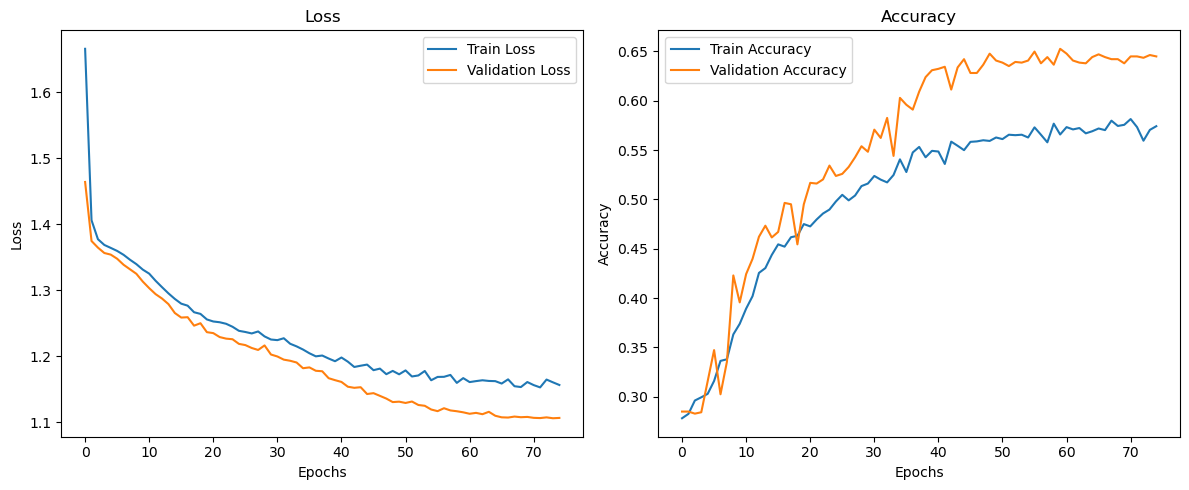

Best Validation Accuracy: 0.58 (Epoch 60)
Best Train Accuracy: 0.58 (Epoch 71)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.6000 - loss: 1.1929
Test Loss: 1.1664729118347168
Test Accuracy: 0.6140350699424744


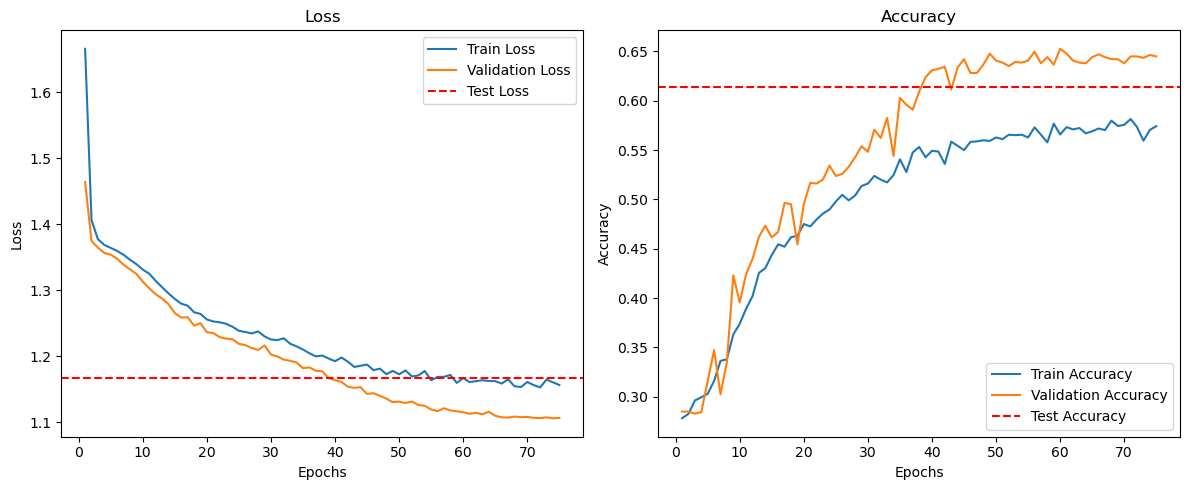

In [15]:
# Call the plot function to display the training history
plot_history(history)

# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


plot_test(history, test_loss, test_accuracy)


## Model 2 - Dropout, one dense layer (excl output layer), no regularization

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Input, Lambda, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt


# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)  # # Dropout rate
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 62s 404ms/step - accuracy: 0.2865 - loss: 1.3728 - val_accuracy: 0.2850 - val_loss: 1.3521 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 386ms/step - accuracy: 0.2957 - loss: 1.3482 - val_accuracy: 0.3438 - val_loss: 1.3291 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 389ms/step - accuracy: 0.3250 - loss: 1.3308 - val_accuracy: 0.3270 - val_loss: 1.2951 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 388ms/step - accuracy: 0.3897 - loss: 1.2924 - val_accuracy: 0.4482 - val_loss: 1.2543 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 388ms/step - accuracy: 0.4402 - loss: 1.2544 - val_accuracy: 0.4741 - val_loss: 1.2189 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 386ms/step - accuracy: 0.4820 - loss: 1.2256 - val_accuracy: 0.4979 - val_loss: 1.1889 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 386ms/step - accuracy: 0.5

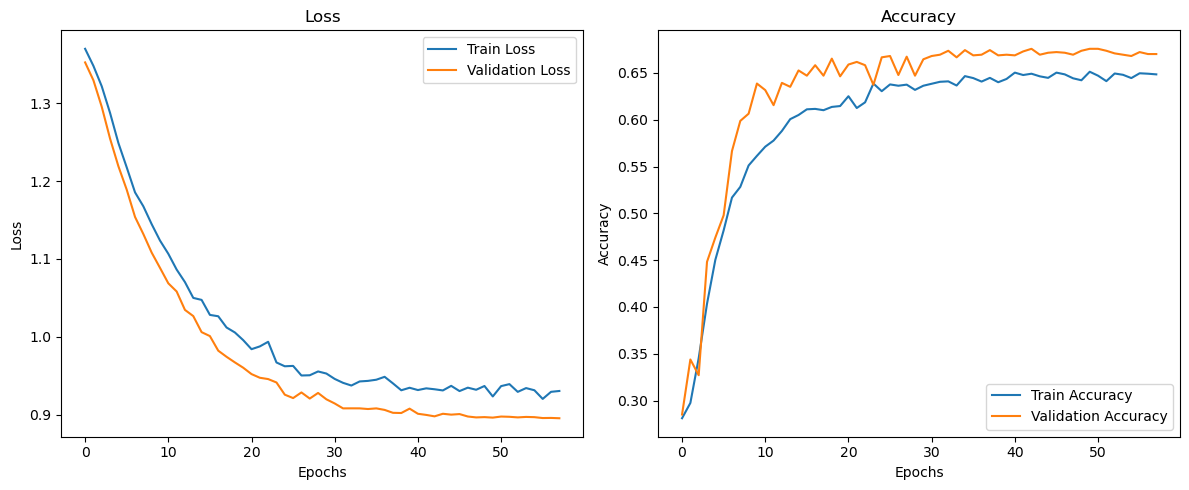

Best Validation Accuracy: 0.65 (Epoch 43)
Best Train Accuracy: 0.65 (Epoch 50)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.5842 - loss: 1.0811
Test Loss: 1.0042556524276733
Test Accuracy: 0.6094584465026855


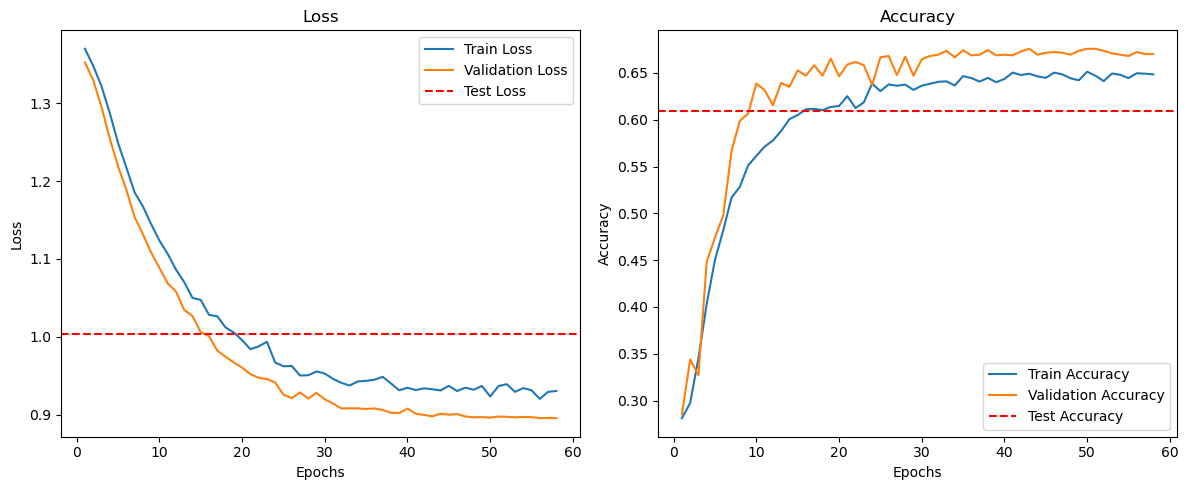

In [17]:
# Call the plot function to display the training history
plot_history(history)


# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)

## Model 3 - no dropout, one dense layer (excl output layer), no regularization, RMSprop

In [18]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)  # # Dropout rate
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 414ms/step - accuracy: 0.2898 - loss: 1.3640 - val_accuracy: 0.2857 - val_loss: 1.3493 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 402ms/step - accuracy: 0.2834 - loss: 1.3517 - val_accuracy: 0.3186 - val_loss: 1.3181 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 406ms/step - accuracy: 0.3382 - loss: 1.3190 - val_accuracy: 0.3557 - val_loss: 1.2839 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 404ms/step - accuracy: 0.3996 - loss: 1.2847 - val_accuracy: 0.3775 - val_loss: 1.2530 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 401ms/step - accuracy: 0.4490 - loss: 1.2478 - val_accuracy: 0.5574 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 402ms/step - accuracy: 0.4914 - loss: 1.2193 - val_accuracy: 0.5728 - val_loss: 1.1793 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 402ms/step - accuracy: 0.5

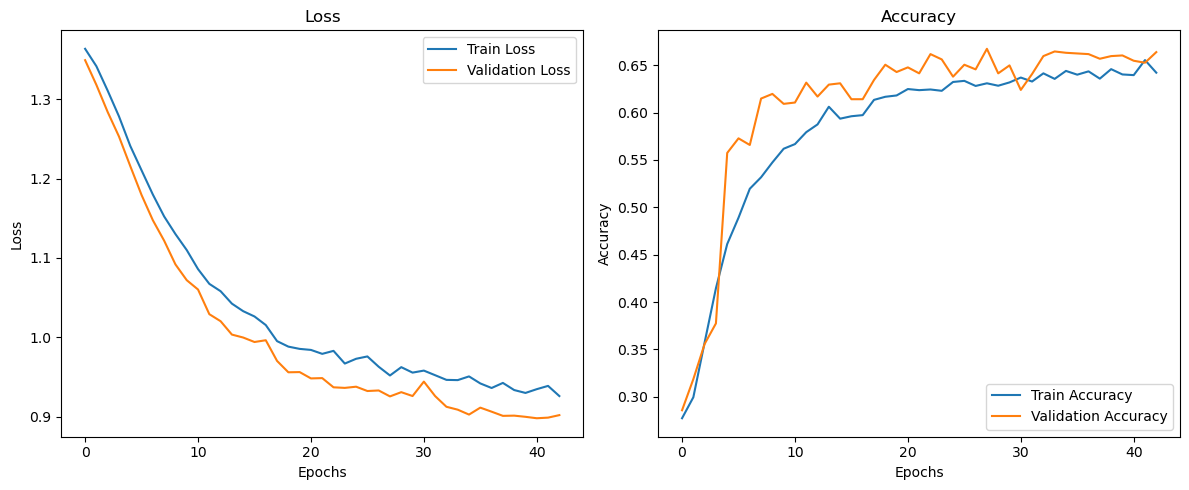

Best Validation Accuracy: 0.66 (Epoch 28)
Best Train Accuracy: 0.66 (Epoch 42)
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - accuracy: 0.6029 - loss: 1.0358
Test Loss: 1.0021300315856934
Test Accuracy: 0.6086956262588501


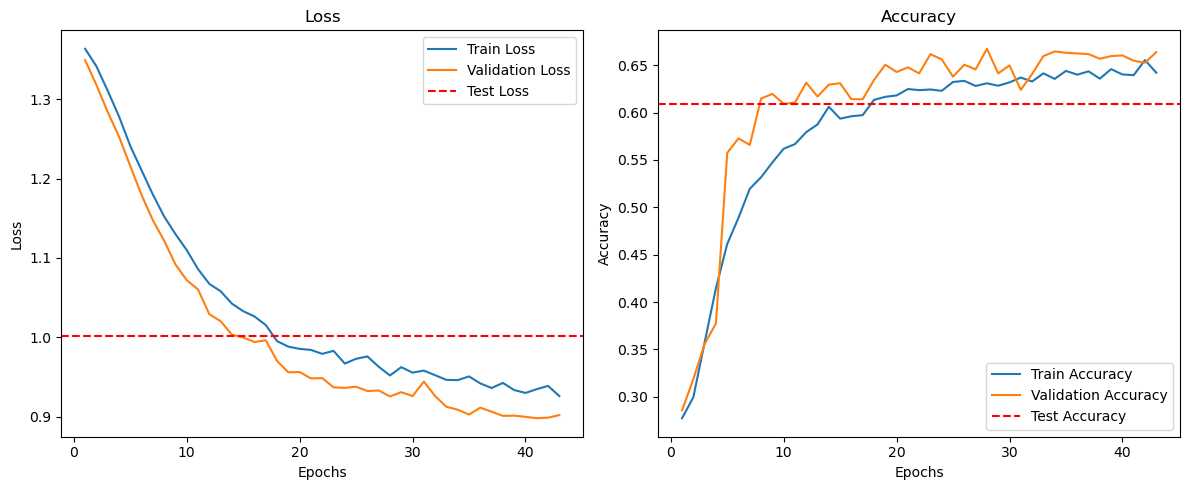

In [19]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Call the function to plot
plot_test(history, test_loss, test_accuracy)

## Model 4 - 2x 0.5 dropout, one dense layer (excl output layer), RMSprop

In [20]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # # Dropout rate
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0))(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 418ms/step - accuracy: 0.2688 - loss: 1.7521 - val_accuracy: 0.2850 - val_loss: 1.4519 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 398ms/step - accuracy: 0.2813 - loss: 1.4230 - val_accuracy: 0.2850 - val_loss: 1.3813 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 398ms/step - accuracy: 0.2772 - loss: 1.3815 - val_accuracy: 0.2836 - val_loss: 1.3736 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 398ms/step - accuracy: 0.2812 - loss: 1.3804 - val_accuracy: 0.2836 - val_loss: 1.3691 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 396ms/step - accuracy: 0.2856 - loss: 1.3721 - val_accuracy: 0.2934 - val_loss: 1.3652 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 55s 407ms/step - accuracy: 0.3092 - loss: 1.3655 - val_accuracy: 0.3011 - val_loss: 1.3606 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 399ms/step - accuracy: 0.3

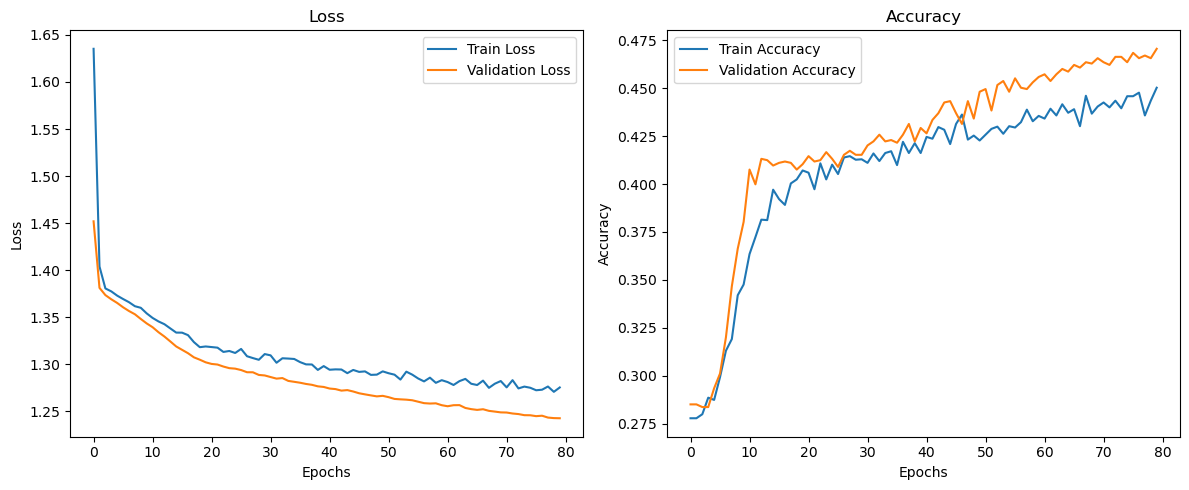

Best Validation Accuracy: 0.45 (Epoch 80)
Best Train Accuracy: 0.45 (Epoch 80)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.4736 - loss: 1.3225
Test Loss: 1.2775013446807861
Test Accuracy: 0.4752097725868225


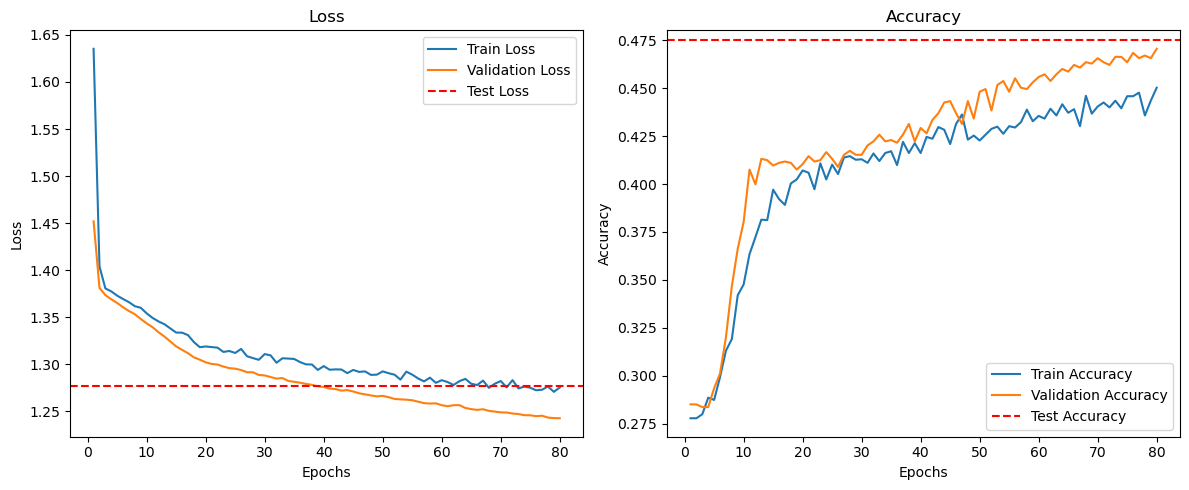

In [21]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 5 - 3 dense layers (excl output layer)

In [22]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,860,916 (91.02 MB)

 Trainable params: 273,204 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 408ms/step - accuracy: 0.2859 - loss: 1.3773 - val_accuracy: 0.3536 - val_loss: 1.3603 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 390ms/step - accuracy: 0.3168 - loss: 1.3496 - val_accuracy: 0.3284 - val_loss: 1.2916 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 397ms/step - accuracy: 0.3862 - loss: 1.2890 - val_accuracy: 0.4328 - val_loss: 1.2026 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 389ms/step - accuracy: 0.4234 - loss: 1.2415 - val_accuracy: 0.4755 - val_loss: 1.1532 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.4508 - loss: 1.1927 - val_accuracy: 0.4076 - val_loss: 1.2071 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 390ms/step - accuracy: 0.4629 - loss: 1.1697 - val_accuracy: 0.4118 - val_loss: 1.1934 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 392ms/step - accuracy: 0.4

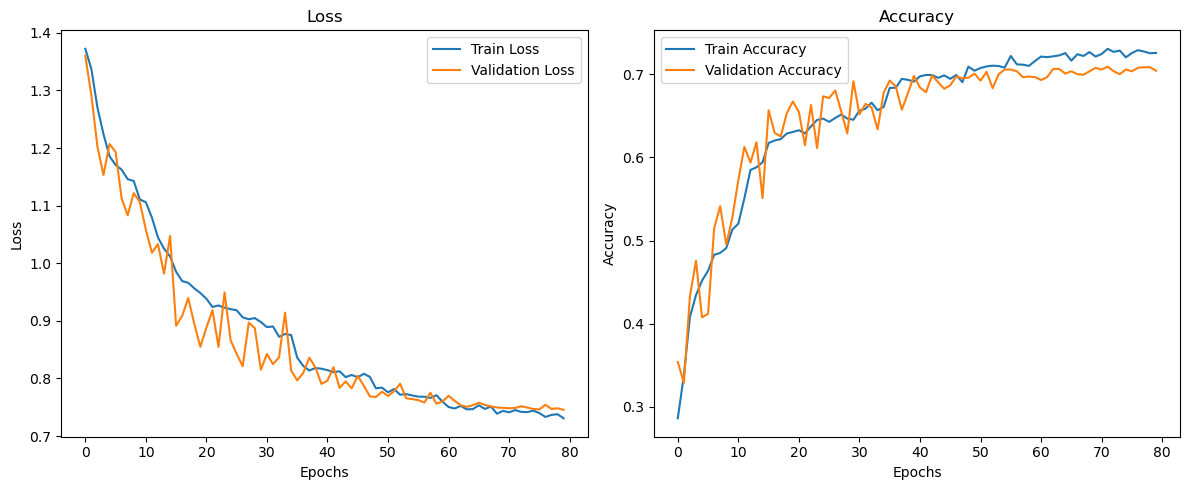

Best Validation Accuracy: 0.73 (Epoch 72)
Best Train Accuracy: 0.73 (Epoch 72)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.6025 - loss: 0.8917
Test Loss: 0.8621153235435486
Test Accuracy: 0.6559877991676331


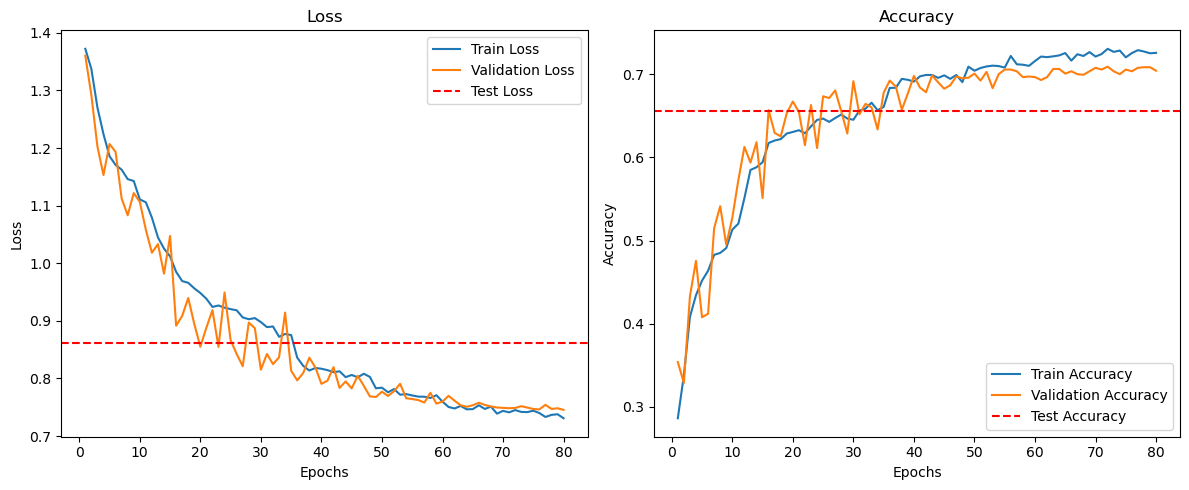

In [23]:
# Call the plot function to display the training history
plot_history(history)

# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 6 - 5 dense layers (excl output layer) & more neurons

In [24]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,156,084 (92.15 MB)

 Trainable params: 568,372 (2.17 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - accuracy: 0.2676 - loss: 1.3768 - val_accuracy: 0.3627 - val_loss: 1.3376 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 403ms/step - accuracy: 0.3636 - loss: 1.3174 - val_accuracy: 0.4538 - val_loss: 1.2511 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 401ms/step - accuracy: 0.4115 - loss: 1.2552 - val_accuracy: 0.4552 - val_loss: 1.1820 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 406ms/step - accuracy: 0.4409 - loss: 1.2141 - val_accuracy: 0.4734 - val_loss: 1.1766 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 404ms/step - accuracy: 0.4554 - loss: 1.1953 - val_accuracy: 0.5070 - val_loss: 1.1194 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 404ms/step - accuracy: 0.4557 - loss: 1.1718 - val_accuracy: 0.4902 - val_loss: 1.1284 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 54s 403ms/step - accuracy: 0.4

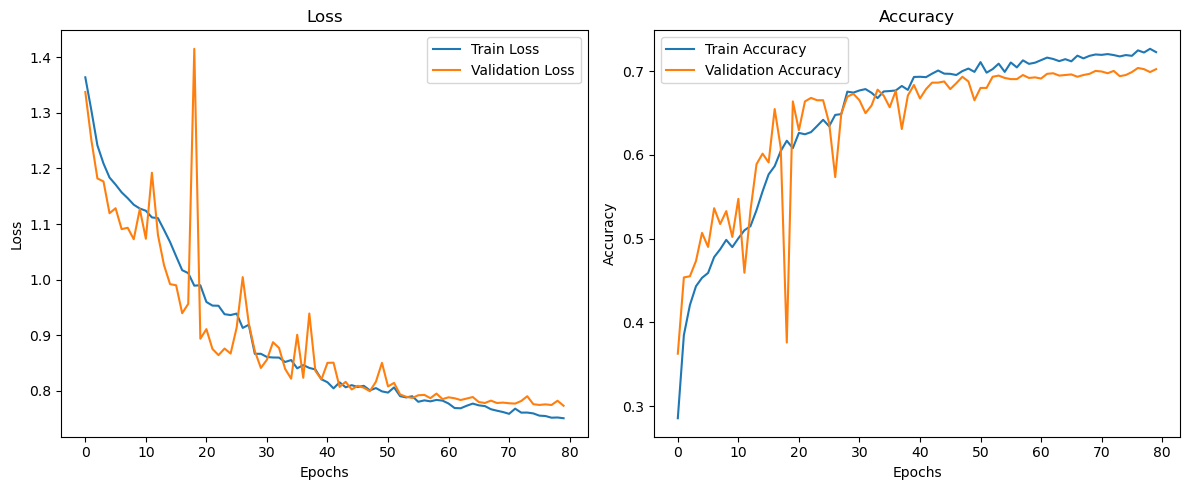

Best Validation Accuracy: 0.73 (Epoch 77)
Best Train Accuracy: 0.73 (Epoch 79)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.6175 - loss: 0.8870
Test Loss: 0.8706966042518616
Test Accuracy: 0.6506483554840088


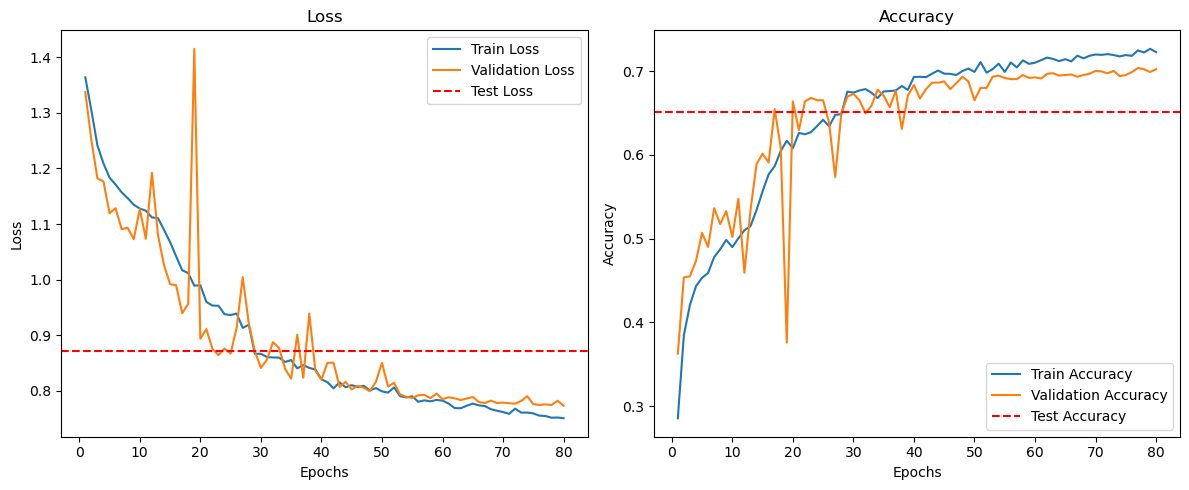

In [25]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 7 - 5 dense layers (excl output layer) & more neurons, ADAM

In [26]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,156,084 (92.15 MB)

 Trainable params: 568,372 (2.17 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 64s 413ms/step - accuracy: 0.2671 - loss: 1.3727 - val_accuracy: 0.3866 - val_loss: 1.3210 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.3817 - loss: 1.2965 - val_accuracy: 0.4181 - val_loss: 1.2453 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.4477 - loss: 1.2146 - val_accuracy: 0.5126 - val_loss: 1.1304 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 396ms/step - accuracy: 0.4907 - loss: 1.1566 - val_accuracy: 0.5630 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.5412 - loss: 1.0906 - val_accuracy: 0.5567 - val_loss: 1.0365 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.5875 - loss: 1.0104 - val_accuracy: 0.6127 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.6

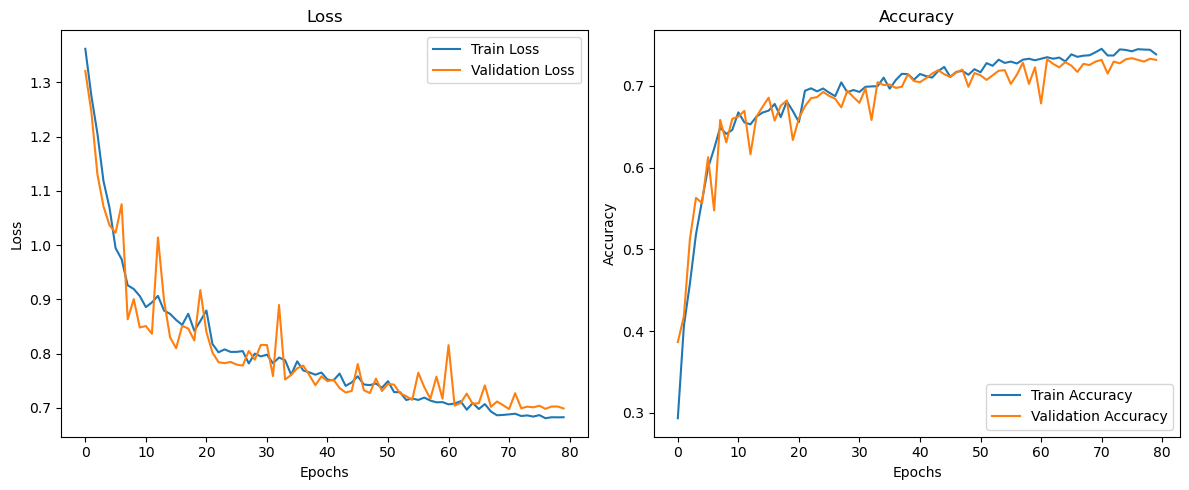

Best Validation Accuracy: 0.75 (Epoch 76)
Best Train Accuracy: 0.75 (Epoch 71)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.5968 - loss: 0.8354
Test Loss: 0.808499813079834
Test Accuracy: 0.662090003490448


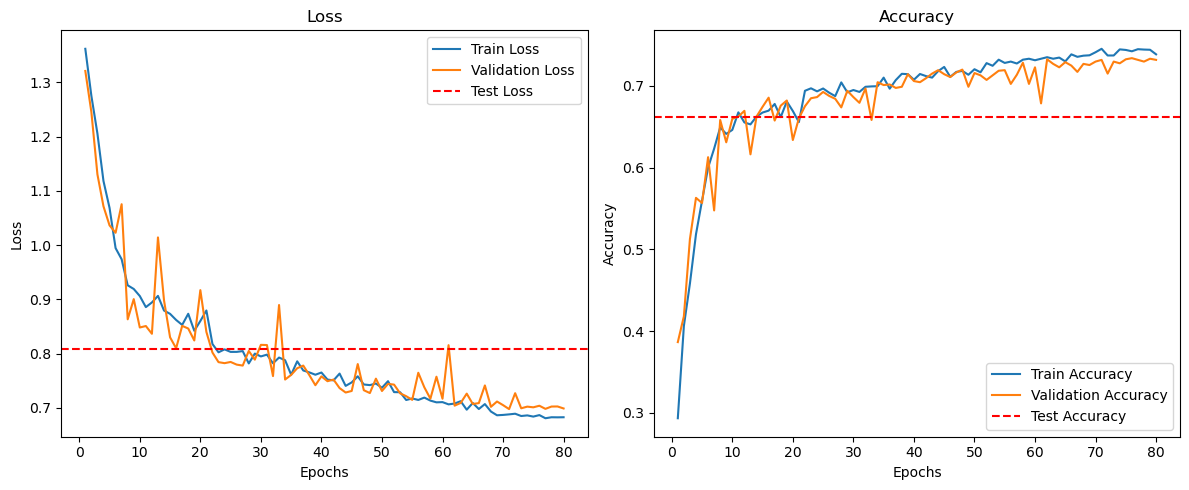

In [27]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 8 - 5 dense layers (excl output layer) & more neurons, ADAM, no reduce RL on plateau

In [30]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,156,084 (92.15 MB)

 Trainable params: 568,372 (2.17 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 493ms/step - accuracy: 0.2587 - loss: 1.3780 - val_accuracy: 0.2871 - val_loss: 1.3451 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 469ms/step - accuracy: 0.3247 - loss: 1.3343 - val_accuracy: 0.4629 - val_loss: 1.1678 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 469ms/step - accuracy: 0.4591 - loss: 1.1802 - val_accuracy: 0.5259 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 62s 460ms/step - accuracy: 0.5030 - loss: 1.1392 - val_accuracy: 0.5343 - val_loss: 1.0904 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 470ms/step - accuracy: 0.5104 - loss: 1.0946 - val_accuracy: 0.5595 - val_loss: 1.0434 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 62s 463ms/step - accuracy: 0.5188 - loss: 1.1059 - val_accuracy: 0.5413 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 61s 453ms/step - accuracy: 0.5

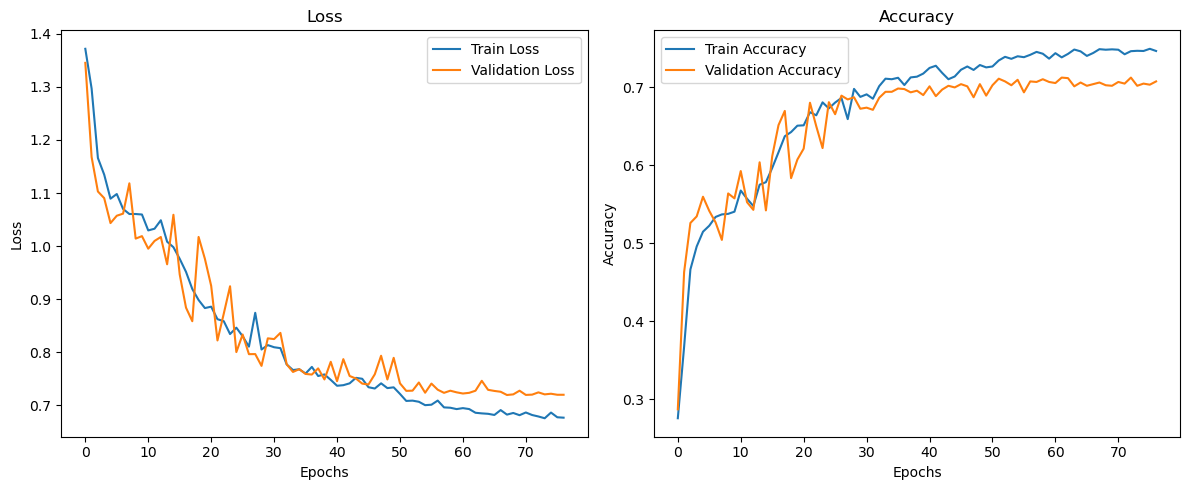

Best Validation Accuracy: 0.75 (Epoch 62)
Best Train Accuracy: 0.75 (Epoch 76)
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.5714 - loss: 0.9075
Test Loss: 0.811390221118927
Test Accuracy: 0.6575133204460144


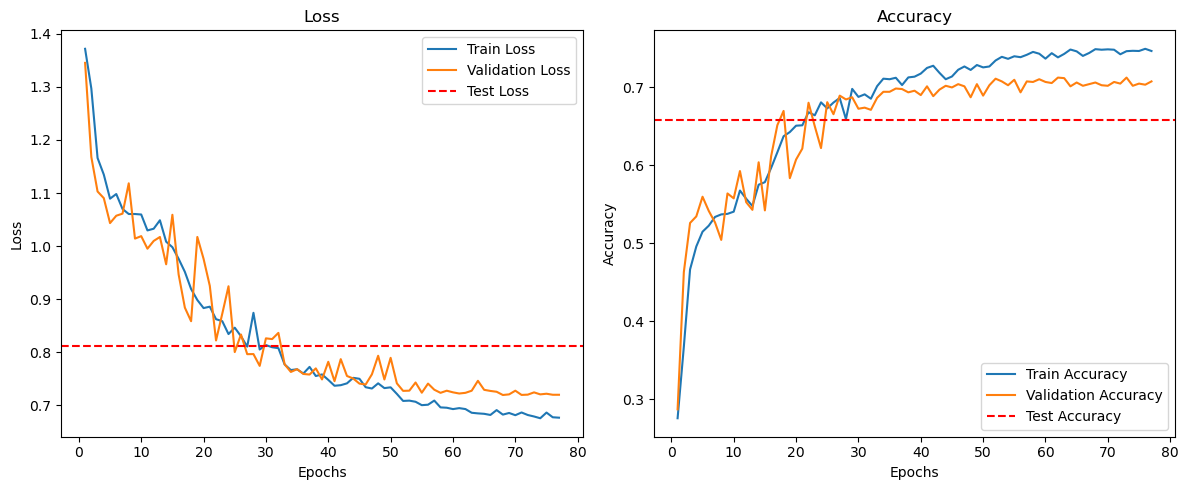

In [31]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 9 - 5 dense layers (excl output layer) & more neurons, lower dropout

In [32]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,156,084 (92.15 MB)

 Trainable params: 568,372 (2.17 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 465ms/step - accuracy: 0.2710 - loss: 1.3801 - val_accuracy: 0.3067 - val_loss: 1.3173 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 55s 412ms/step - accuracy: 0.4138 - loss: 1.2546 - val_accuracy: 0.4314 - val_loss: 1.1959 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 417ms/step - accuracy: 0.4858 - loss: 1.1358 - val_accuracy: 0.5371 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 435ms/step - accuracy: 0.5158 - loss: 1.0936 - val_accuracy: 0.4902 - val_loss: 1.1534 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 423ms/step - accuracy: 0.5091 - loss: 1.0896 - val_accuracy: 0.5217 - val_loss: 1.0853 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 427ms/step - accuracy: 0.5366 - loss: 1.0590 - val_accuracy: 0.5161 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 435ms/step - accuracy: 0.5

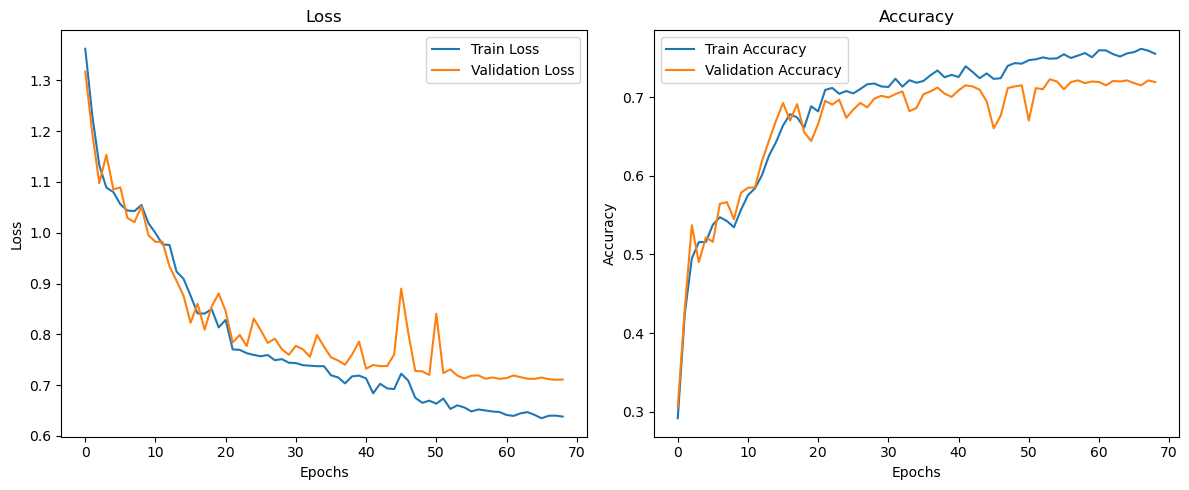

Best Validation Accuracy: 0.76 (Epoch 54)
Best Train Accuracy: 0.76 (Epoch 67)
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - accuracy: 0.6046 - loss: 0.9094
Test Loss: 0.8180683851242065
Test Accuracy: 0.6720061302185059


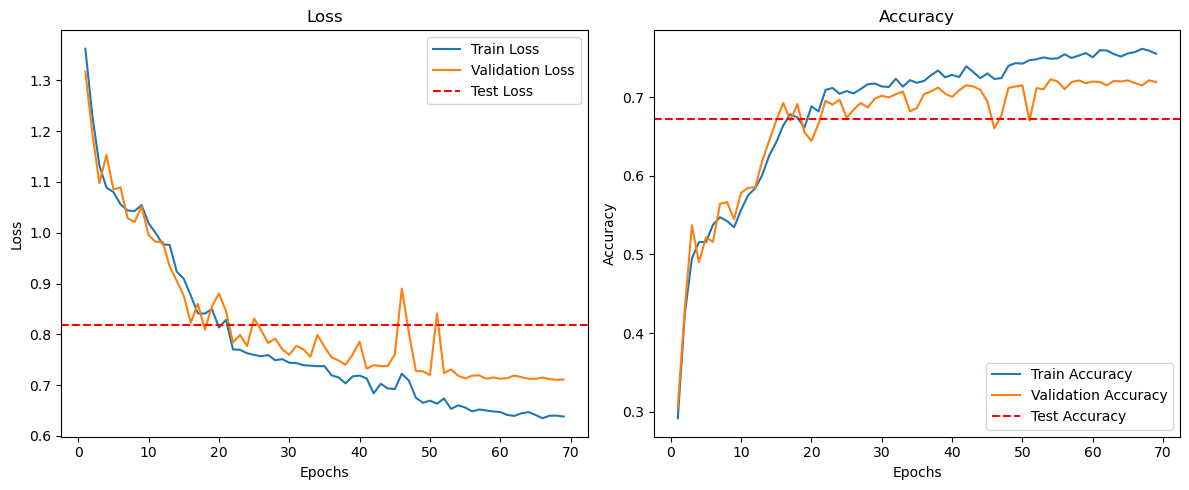

In [33]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 10 - 5 dense layers (excl output layer) & more neurons, no dropout

In [34]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_14[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,156,084 (92.15 MB)

 Trainable params: 568,372 (2.17 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 444ms/step - accuracy: 0.2759 - loss: 1.3751 - val_accuracy: 0.2878 - val_loss: 1.3400 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 433ms/step - accuracy: 0.3429 - loss: 1.3016 - val_accuracy: 0.3782 - val_loss: 1.2546 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 442ms/step - accuracy: 0.4950 - loss: 1.1291 - val_accuracy: 0.4783 - val_loss: 1.1386 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 432ms/step - accuracy: 0.5362 - loss: 1.0598 - val_accuracy: 0.4944 - val_loss: 1.1465 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 421ms/step - accuracy: 0.5408 - loss: 1.0755 - val_accuracy: 0.5182 - val_loss: 1.0784 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 416ms/step - accuracy: 0.5576 - loss: 1.0256 - val_accuracy: 0.5966 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 427ms/step - accuracy: 0.5

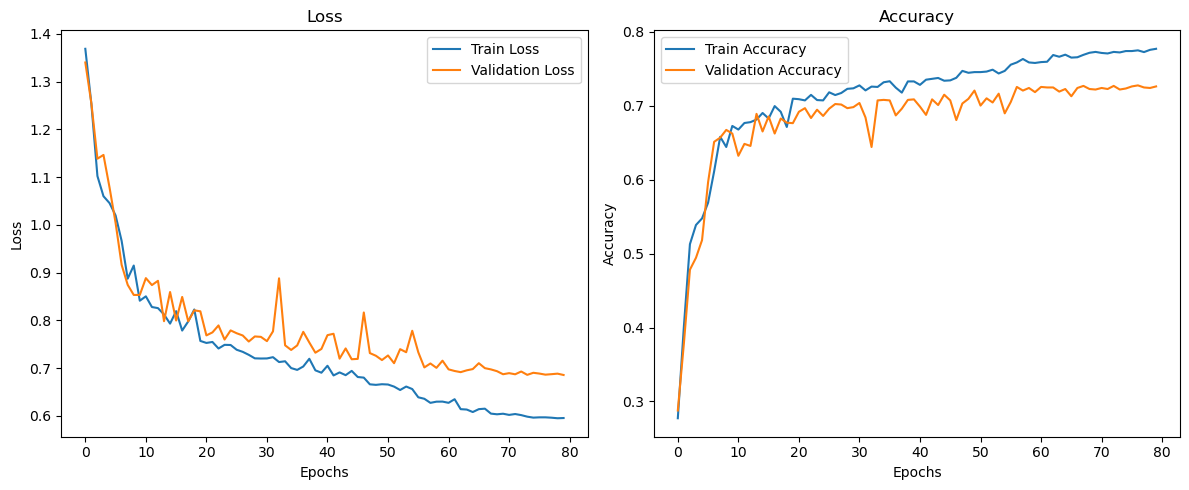

Best Validation Accuracy: 0.78 (Epoch 77)
Best Train Accuracy: 0.78 (Epoch 80)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - accuracy: 0.6195 - loss: 0.8682
Test Loss: 0.8017451763153076
Test Accuracy: 0.6788710951805115


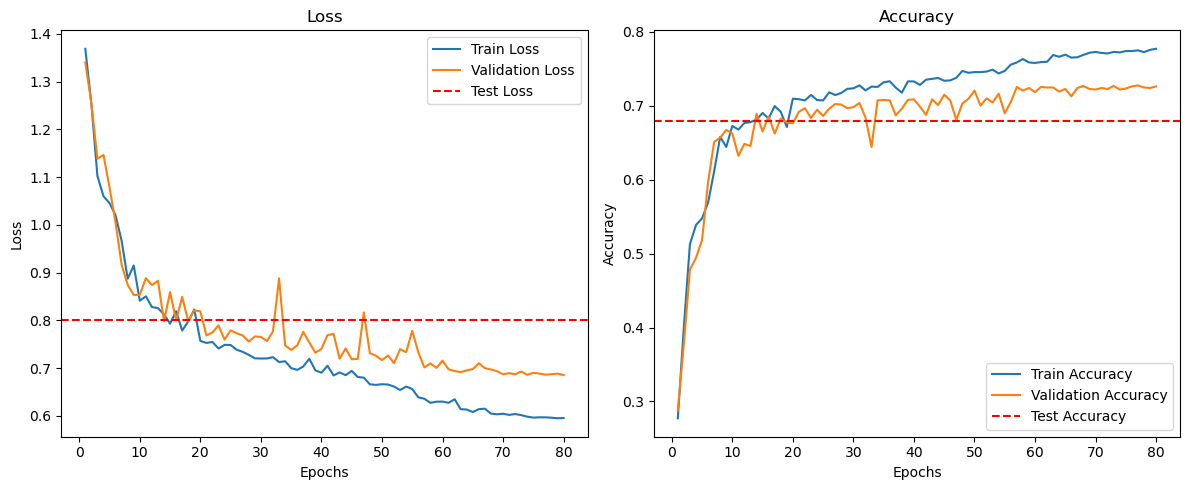

In [35]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 11 - 6 dense layers (excl output layer) & more neurons, 0.2 dropout

In [36]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_15[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,811,956 (94.65 MB)

 Trainable params: 1,224,244 (4.67 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 464ms/step - accuracy: 0.2768 - loss: 1.3574 - val_accuracy: 0.4762 - val_loss: 1.1788 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 441ms/step - accuracy: 0.4602 - loss: 1.1782 - val_accuracy: 0.5084 - val_loss: 1.1149 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 434ms/step - accuracy: 0.5262 - loss: 1.0997 - val_accuracy: 0.4944 - val_loss: 1.1196 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 422ms/step - accuracy: 0.5309 - loss: 1.0768 - val_accuracy: 0.5469 - val_loss: 1.0610 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 59s 439ms/step - accuracy: 0.5368 - loss: 1.0556 - val_accuracy: 0.5413 - val_loss: 1.0603 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 62s 461ms/step - accuracy: 0.5509 - loss: 1.0512 - val_accuracy: 0.5819 - val_loss: 1.0280 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 65s 484ms/step - accuracy: 0.5

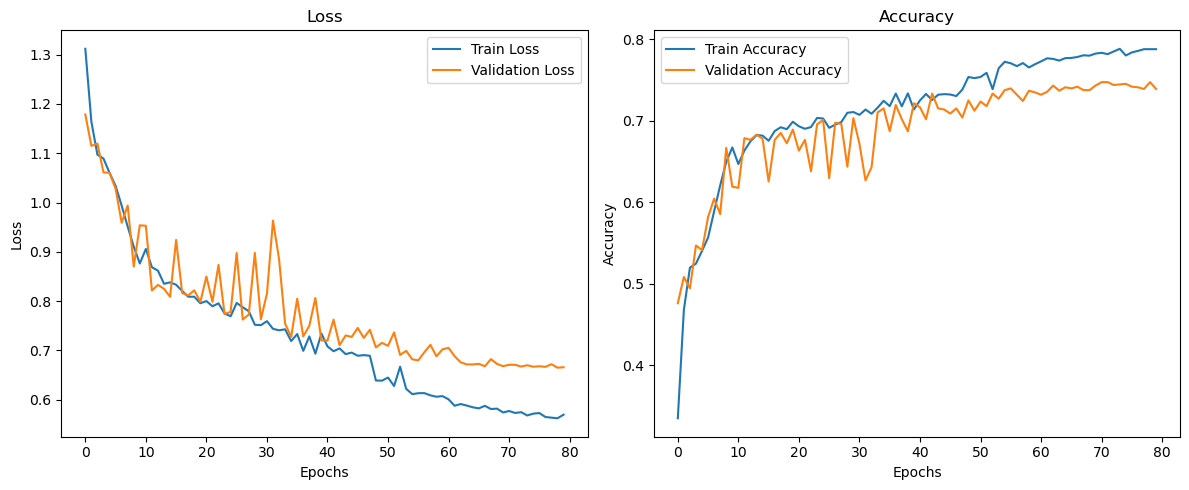

Best Validation Accuracy: 0.79 (Epoch 71)
Best Train Accuracy: 0.79 (Epoch 74)
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - accuracy: 0.6498 - loss: 0.8039
Test Loss: 0.7783501744270325
Test Accuracy: 0.6926010847091675


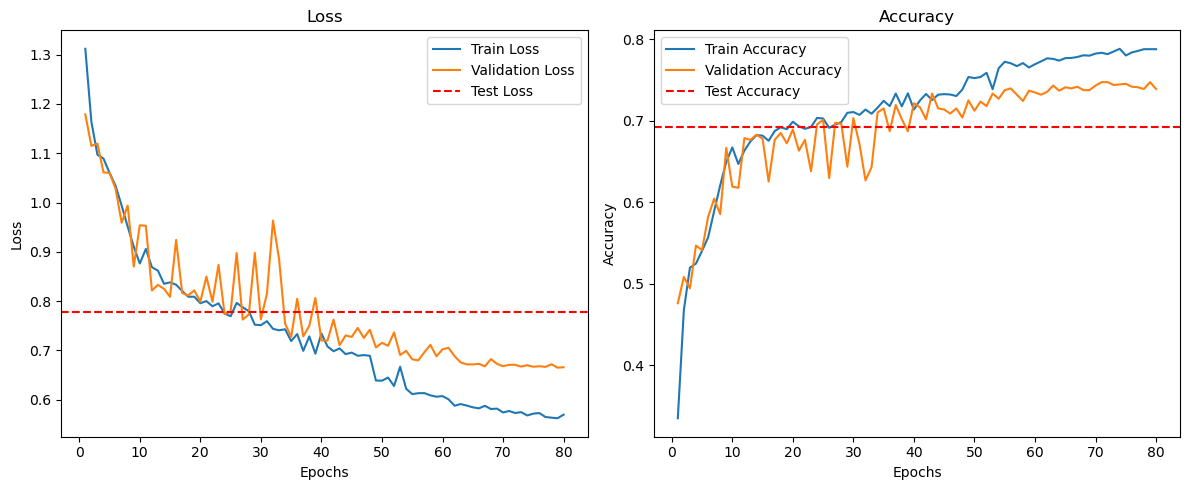

In [37]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 12 - 8 dense layers (excl output layer) & more neurons, 0.5 dropout

In [38]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_16[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 26,385,948 (100.65 MB)

 Trainable params: 2,798,236 (10.67 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 496ms/step - accuracy: 0.2676 - loss: 1.3819 - val_accuracy: 0.3662 - val_loss: 1.3117 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 65s 483ms/step - accuracy: 0.3620 - loss: 1.3249 - val_accuracy: 0.4223 - val_loss: 1.1983 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 64s 481ms/step - accuracy: 0.3980 - loss: 1.2561 - val_accuracy: 0.4594 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 66s 491ms/step - accuracy: 0.4250 - loss: 1.1907 - val_accuracy: 0.5049 - val_loss: 1.1238 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 472ms/step - accuracy: 0.4646 - loss: 1.1614 - val_accuracy: 0.5105 - val_loss: 1.1187 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 61s 459ms/step - accuracy: 0.4823 - loss: 1.1573 - val_accuracy: 0.5119 - val_loss: 1.1214 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 61s 456ms/step - accuracy: 0.4

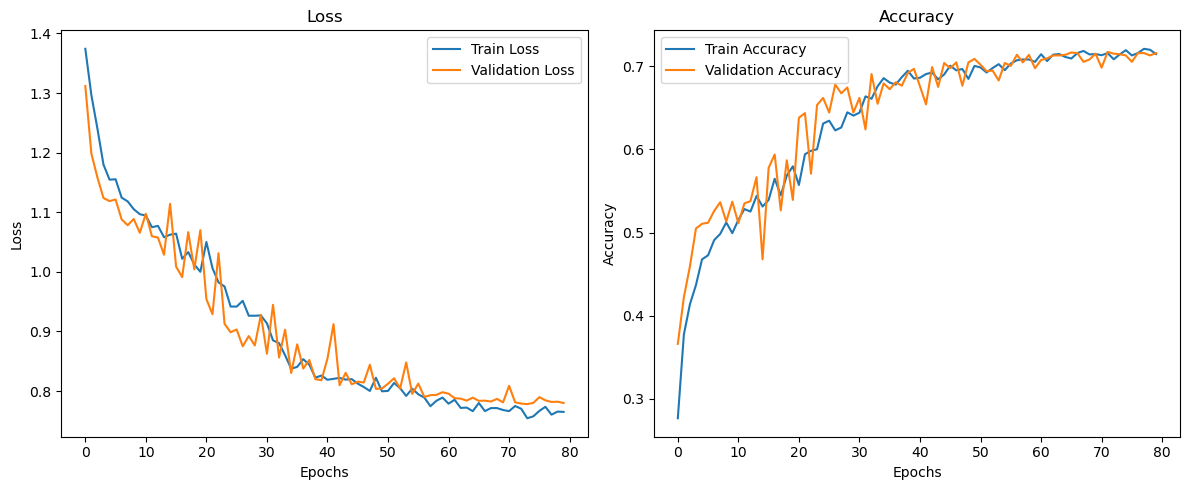

Best Validation Accuracy: 0.72 (Epoch 72)
Best Train Accuracy: 0.72 (Epoch 78)
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.5677 - loss: 0.9374
Test Loss: 0.8620789051055908
Test Accuracy: 0.6437833905220032


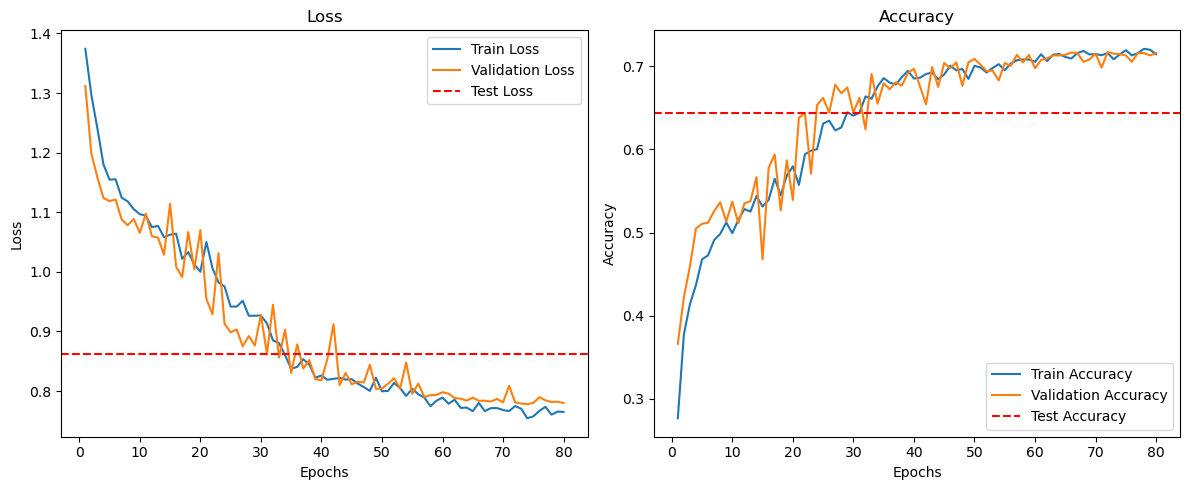

In [39]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


# 5. VGG16 Tuning

## Model 1 - VGG16 with 5 dense layers

In [40]:
# Load VGG16 with ImageNet weights, using the modified input
net = VGG16(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,889,844 (56.80 MB)

 Trainable params: 175,156 (684.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 130s 951ms/step - accuracy: 0.2486 - loss: 1.3860 - val_accuracy: 0.2850 - val_loss: 1.3825 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 126s 945ms/step - accuracy: 0.2790 - loss: 1.3802 - val_accuracy: 0.3732 - val_loss: 1.2885 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 122s 912ms/step - accuracy: 0.3809 - loss: 1.2854 - val_accuracy: 0.3978 - val_loss: 1.2378 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 121s 907ms/step - accuracy: 0.3991 - loss: 1.2280 - val_accuracy: 0.4118 - val_loss: 1.2453 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 122s 912ms/step - accuracy: 0.3950 - loss: 1.2455 - val_accuracy: 0.4083 - val_loss: 1.2205 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 125s 937ms/step - accuracy: 0.4036 - loss: 1.2121 - val_accuracy: 0.4104 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 131s 977ms/step - accura

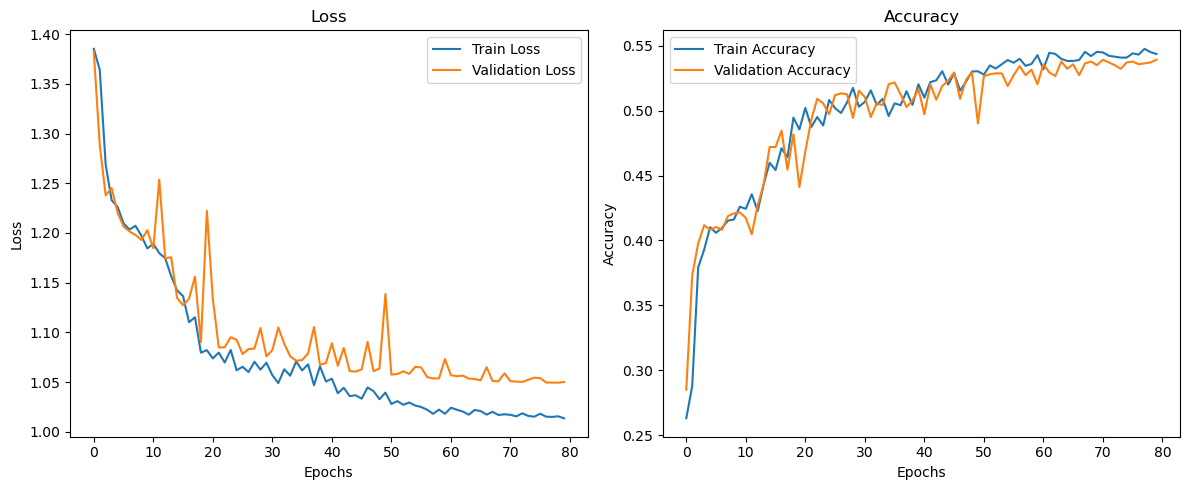

Best Validation Accuracy: 0.55 (Epoch 71)
Best Train Accuracy: 0.55 (Epoch 78)
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 608ms/step - accuracy: 0.4604 - loss: 1.1190
Test Loss: 1.0765646696090698
Test Accuracy: 0.5194507837295532


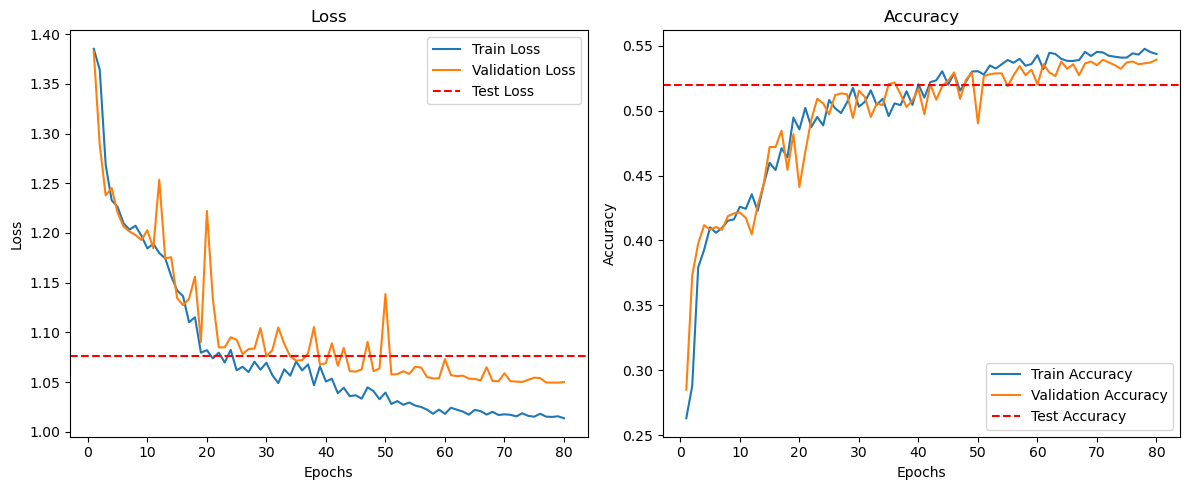

In [41]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 2 - VGG16 with 6 dense layers

In [42]:
# Load VGG16 with ImageNet weights, using the modified input
net = VGG16(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,152,500 (57.80 MB)

 Trainable params: 437,812 (1.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 113s 825ms/step - accuracy: 0.2729 - loss: 1.3804 - val_accuracy: 0.3950 - val_loss: 1.2636 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 819ms/step - accuracy: 0.3694 - loss: 1.2693 - val_accuracy: 0.4027 - val_loss: 1.2366 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 816ms/step - accuracy: 0.4115 - loss: 1.2175 - val_accuracy: 0.4146 - val_loss: 1.2034 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 822ms/step - accuracy: 0.4291 - loss: 1.2015 - val_accuracy: 0.4440 - val_loss: 1.2291 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 815ms/step - accuracy: 0.4240 - loss: 1.1915 - val_accuracy: 0.4027 - val_loss: 1.2545 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 813ms/step - accuracy: 0.4362 - loss: 1.1871 - val_accuracy: 0.4384 - val_loss: 1.1947 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 816ms/step - accura

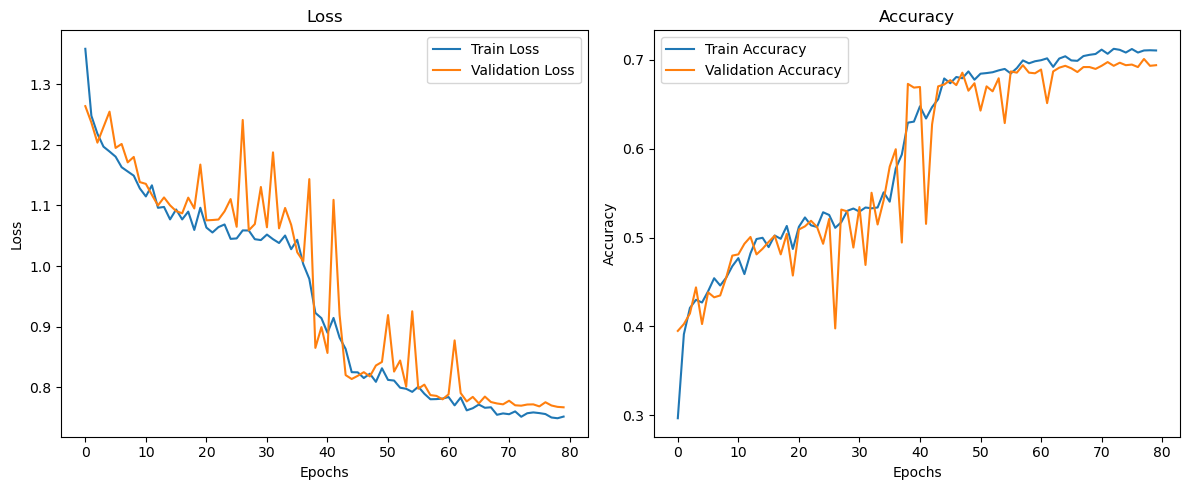

Best Validation Accuracy: 0.71 (Epoch 78)
Best Train Accuracy: 0.71 (Epoch 73)
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 651ms/step - accuracy: 0.5794 - loss: 0.9391
Test Loss: 0.871502161026001
Test Accuracy: 0.6392067074775696


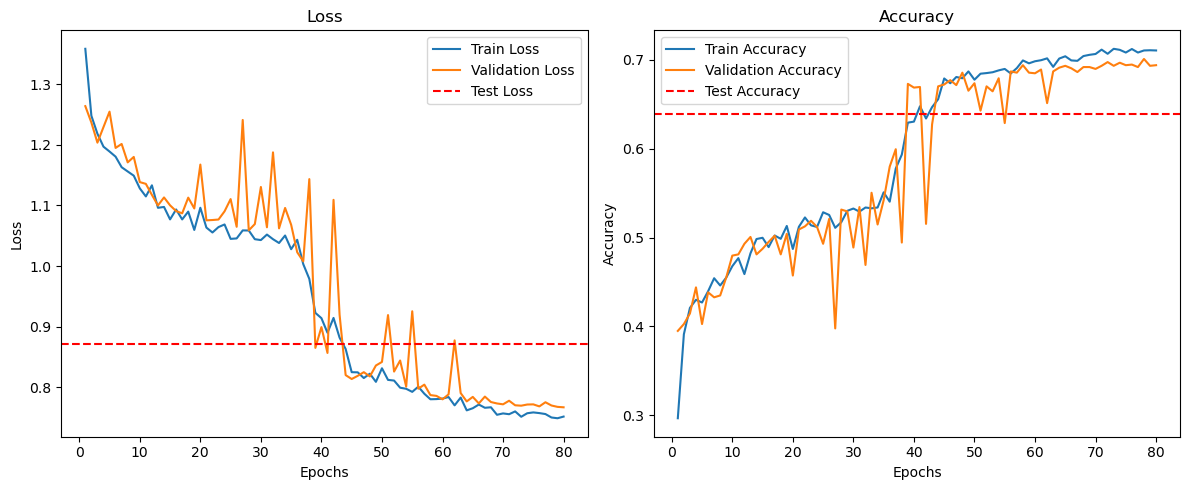

In [43]:
# Call the plot function to display the training history
plot_history(history)

# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 3 - VGG16 with 8 dense layers

In [44]:
# Load VGG16 with ImageNet weights, using the modified input
net = VGG16(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,940,060 (60.81 MB)

 Trainable params: 1,225,372 (4.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 117s 852ms/step - accuracy: 0.2683 - loss: 1.3849 - val_accuracy: 0.3697 - val_loss: 1.2994 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 113s 848ms/step - accuracy: 0.3562 - loss: 1.2912 - val_accuracy: 0.3782 - val_loss: 1.2460 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 114s 848ms/step - accuracy: 0.3847 - loss: 1.2497 - val_accuracy: 0.3894 - val_loss: 1.2267 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 114s 849ms/step - accuracy: 0.3940 - loss: 1.2173 - val_accuracy: 0.3796 - val_loss: 1.2079 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 113s 846ms/step - accuracy: 0.3973 - loss: 1.2122 - val_accuracy: 0.4244 - val_loss: 1.1980 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 114s 853ms/step - accuracy: 0.4323 - loss: 1.2029 - val_accuracy: 0.4251 - val_loss: 1.1881 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 113s 847ms/step - accura

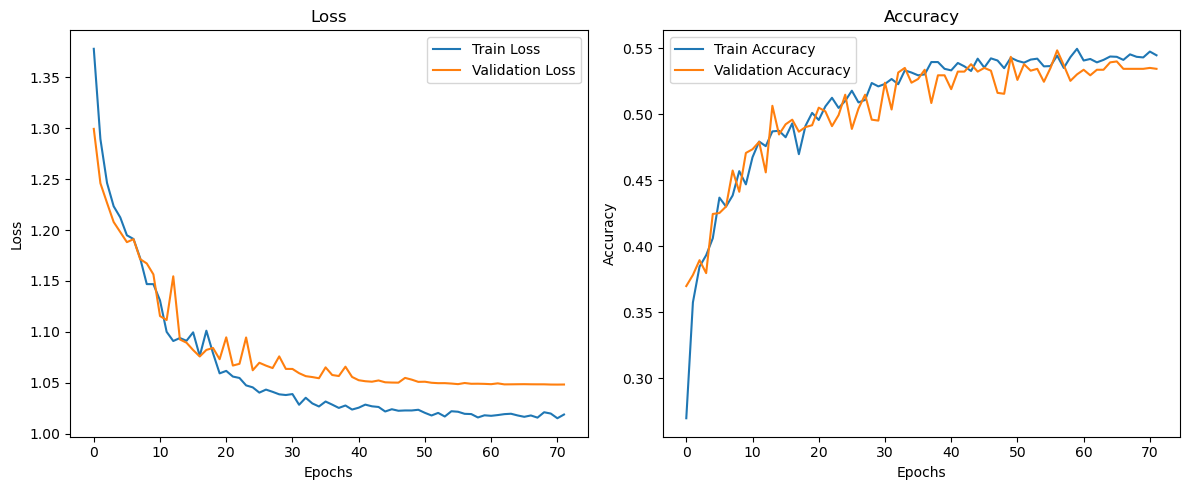

Best Validation Accuracy: 0.55 (Epoch 57)
Best Train Accuracy: 0.55 (Epoch 60)
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 689ms/step - accuracy: 0.4190 - loss: 1.1199
Test Loss: 1.0584821701049805
Test Accuracy: 0.514111340045929


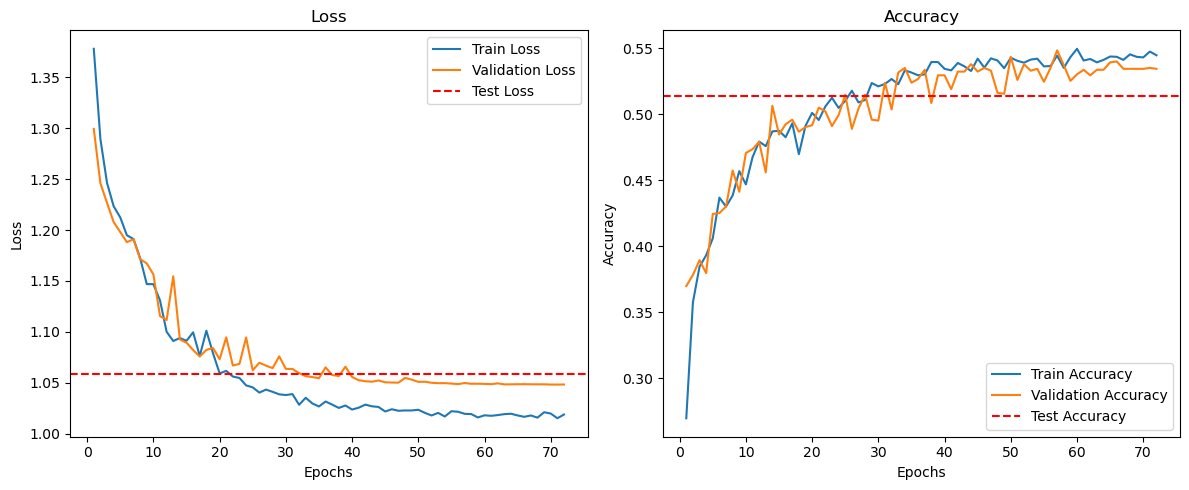

In [46]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Call the function to plot
plot_test(history, test_loss, test_accuracy)


# 6. DenseNet121 Tuning

## Model 1 - DenseNet with 5 layers

In [ ]:
# Load DenseNet121 with ImageNet weights, using the modified input
net = DenseNet121(
    weights=None,  # Set to None if you don't want pre-trained weights; 'imagenet' otherwise
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n layers
for layer in net.layers:
    layer.trainable = False

# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Adjust the number of classes as necessary

# Create the model
model = Model(inputs=net.input, outputs=output)

# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)

# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,343,732 (28.01 MB)

 Trainable params: 306,228 (1.17 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/80


C:\Users\Chrollo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 66s 393ms/step - accuracy: 0.2691 - loss: 1.3676 - val_accuracy: 0.4787 - val_loss: 1.1850 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 355ms/step - accuracy: 0.4964 - loss: 1.1557 - val_accuracy: 0.5010 - val_loss: 1.1125 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 428ms/step - accuracy: 0.5280 - loss: 1.0710 - val_accuracy: 0.5409 - val_loss: 1.0478 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 396ms/step - accuracy: 0.5517 - loss: 1.0524 - val_accuracy: 0.5829 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 433ms/step - accuracy: 0.5920 - loss: 1.0063 - val_accuracy: 0.6249 - val_loss: 0.9265 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 375ms/step - accuracy: 0.6357 - loss: 0.9324 - val_accuracy: 0.6417 - val_loss: 0.9267 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 43s 320ms/step - accuracy: 0.6526 - loss:

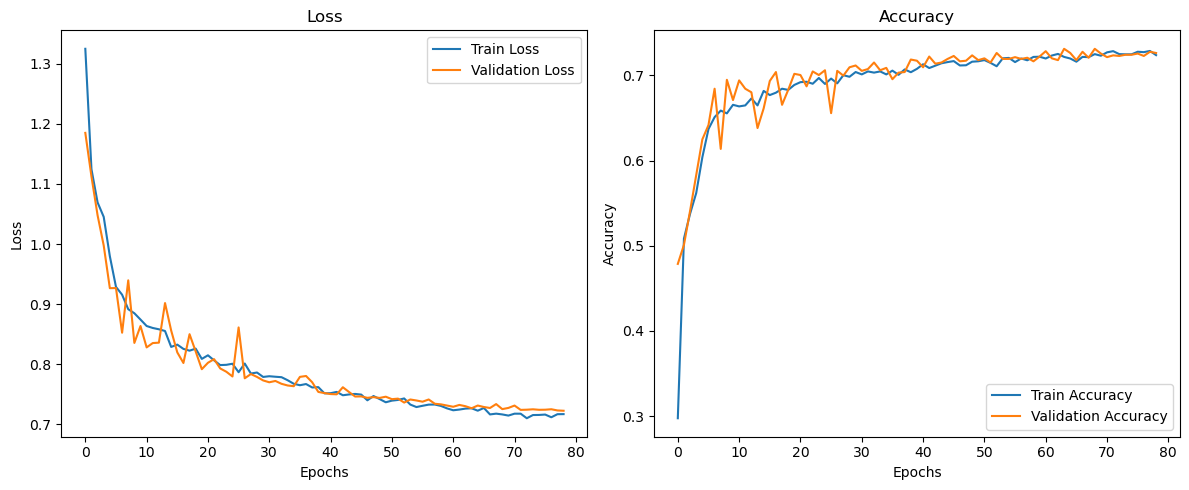

Best Validation Accuracy: 0.73 (Epoch 64)
Best Train Accuracy: 0.73 (Epoch 78)
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.5893 - loss: 0.9157
Test Loss: 0.8528132438659668
Test Accuracy: 0.6402438879013062


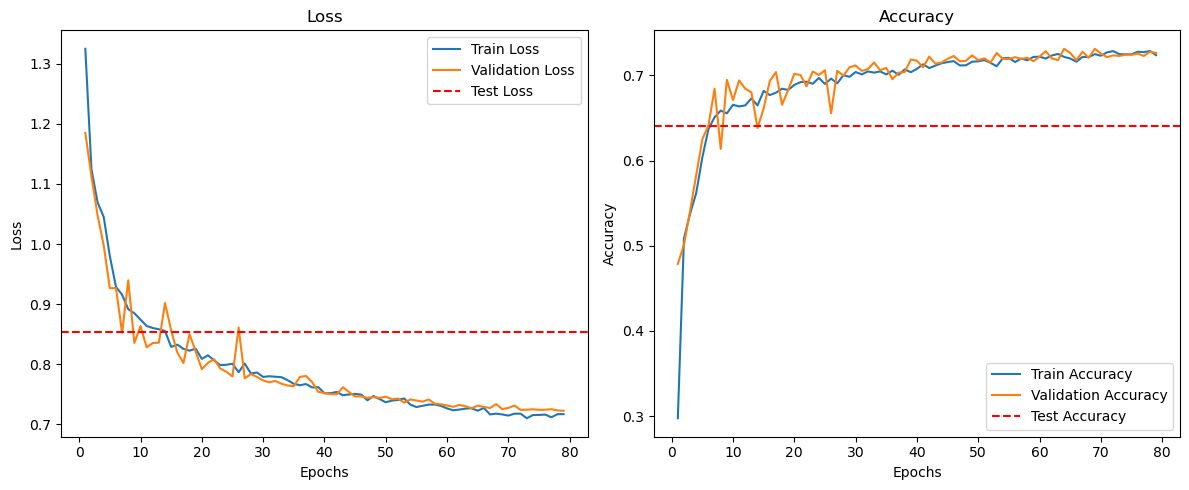

In [ ]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Call the function to plot
plot_test(history, test_loss, test_accuracy)


## Model 2 - DenseNet with 6 layers

In [ ]:
# Load DenseNet121 with ImageNet weights, using the modified input
net = DenseNet121(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_12   │ (None, None,      │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d_1… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_13   │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,737,460 (29.52 MB)

 Trainable params: 699,956 (2.67 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.2742 - loss: 1.3727 - val_accuracy: 0.4419 - val_loss: 1.2054 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.4643 - loss: 1.1680 - val_accuracy: 0.4398 - val_loss: 1.1503 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.5157 - loss: 1.1023 - val_accuracy: 0.5035 - val_loss: 1.0977 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.5495 - loss: 1.0660 - val_accuracy: 0.5476 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.5712 - loss: 1.0238 - val_accuracy: 0.6085 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 230ms/step - accuracy: 0.6266 - loss: 0.9591 - val_accuracy: 0.6471 - val_loss: 0.9113 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.6

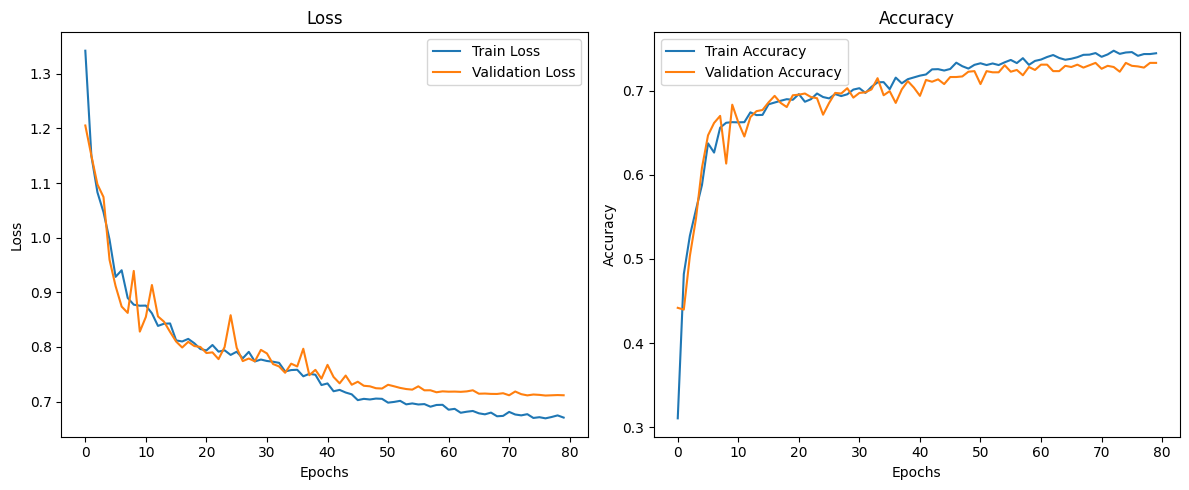

Best Validation Accuracy: 0.75 (Epoch 70)
Best Train Accuracy: 0.75 (Epoch 73)
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.6214 - loss: 0.8577
Test Loss: 0.8260201811790466
Test Accuracy: 0.6666666865348816


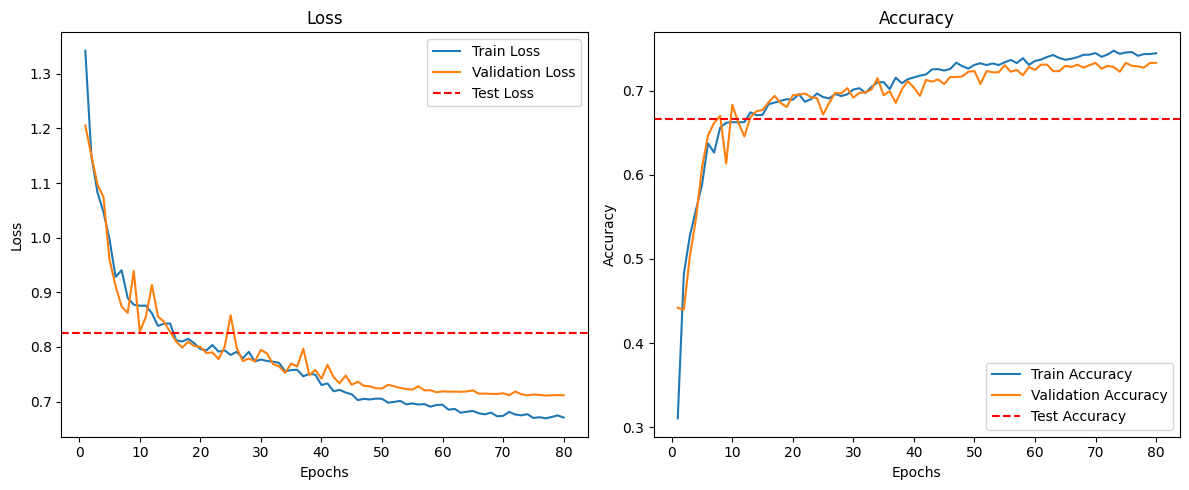

In [ ]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Call the function to plot
plot_test(history, test_loss, test_accuracy)

## Model 3 - DenseNet with 8 layers

In [ ]:
# Load DenseNet121 with ImageNet weights, using the modified input
net = DenseNet121(
    weights=None,  
    include_top=False,   # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
output = Dense(4, activation='softmax')(x) # Do not change # of kernels/neurons
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, None,      │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d_1… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 8,787,164 (33.52 MB)

 Trainable params: 1,749,660 (6.67 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.3037 - loss: 1.3434 - val_accuracy: 0.4706 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 2/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.5041 - loss: 1.1275 - val_accuracy: 0.5252 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 3/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.5280 - loss: 1.1030 - val_accuracy: 0.5490 - val_loss: 1.0781 - learning_rate: 0.0010
Epoch 4/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 34s 252ms/step - accuracy: 0.5330 - loss: 1.0933 - val_accuracy: 0.5238 - val_loss: 1.0866 - learning_rate: 0.0010
Epoch 5/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 33s 249ms/step - accuracy: 0.5389 - loss: 1.0659 - val_accuracy: 0.5203 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 6/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 33s 244ms/step - accuracy: 0.5727 - loss: 1.0408 - val_accuracy: 0.5756 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 7/80
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - accuracy: 0.5

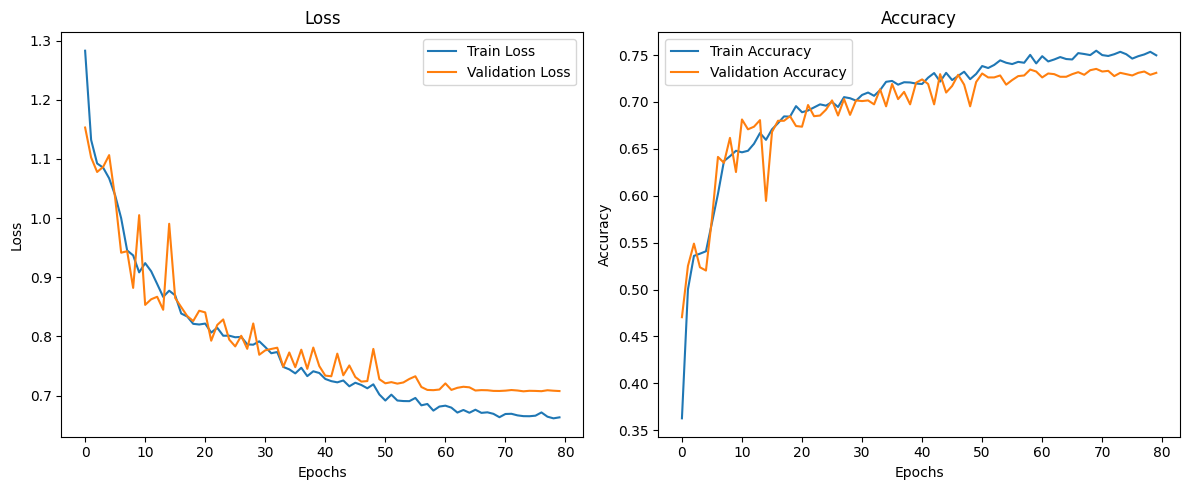

Best Validation Accuracy: 0.75 (Epoch 70)
Best Train Accuracy: 0.75 (Epoch 70)
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.6222 - loss: 0.8738
Test Loss: 0.8248664140701294
Test Accuracy: 0.6712433099746704


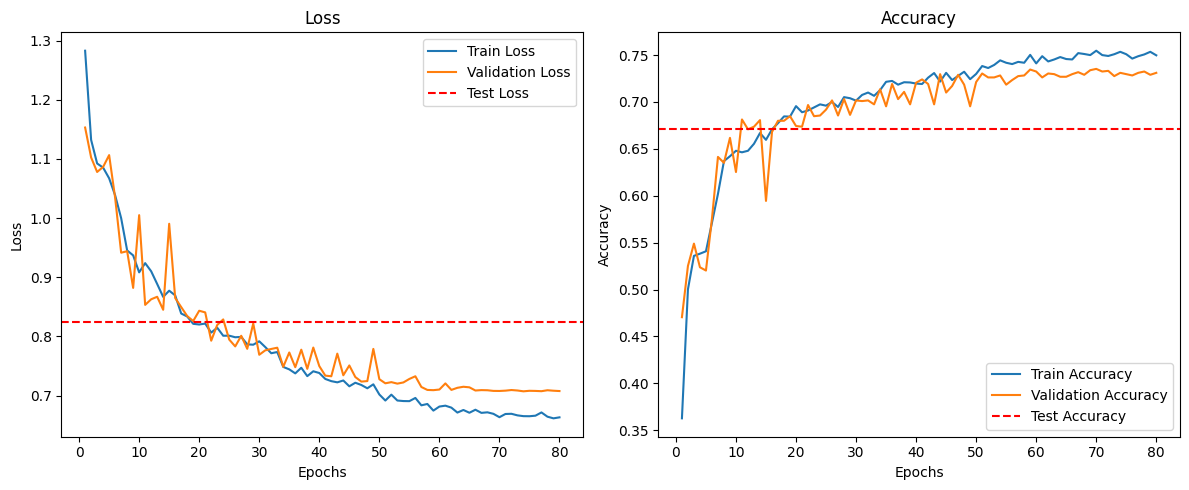

In [ ]:
# Call the plot function to display the training history
plot_history(history)



# Extract the best validation accuracy
best_val_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_train_epoch = history.history['accuracy'].index(max(history.history['accuracy'])) + 1
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy = max(history.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_accuracy:.2f} (Epoch {best_val_epoch})")
print(f"Best Train Accuracy: {best_val_accuracy:.2f} (Epoch {best_train_epoch})")


# Evaluate model performance on the test data 
test_loss, test_accuracy = model.evaluate(test_data_rescaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Call the function to plot
plot_test(history, test_loss, test_accuracy)